# Building an image model from results obtained by fitting:

## M51 test image

Initially we fit the M51 test image; then, from the fit results we build a model, and finally we subtract the model from the original image.

In [1]:
from astropy.io import fits
image = fits.open("../../test/data/M51.fits")
pixel_data = image[0].data

from ellipse.ellipse import Ellipse
ellipse = Ellipse(pixel_data)
isolist = ellipse.fit_image(sclip=2., nclip=3)

Centering on object....   Done. Found x0 = 257.0, y0 = 258.0
#
# Semi-      Isophote         Ellipticity    Position     Grad.   Data  Flag Iter. Stop
# major        mean                           Angle        rel.                    code
# axis       intensity                                    error
#(pixel)                                     (degree)
#
  10.00     1089.59 ( 8.44)  0.102 (0.006)  65.93 ( 2.0)  0.191    60     0   20     0
  11.00     1044.70 ( 7.70)  0.132 (0.005)  72.93 ( 1.1)  0.150    65     0   10     0
  12.10      983.21 ( 5.88)  0.157 (0.003)  70.03 ( 0.6)  0.122    61     9   10     0
  13.31      916.06 ( 7.32)  0.157 (0.006)  49.90 ( 1.3)  0.216    70     7   50     2
  14.64      895.94 ( 6.87)  0.223 (0.004)  55.85 ( 0.7)  0.160    77     4   19     0
  16.11      868.99 ( 5.41)  0.282 (0.003)  51.85 ( 0.5)  0.152    76    10   12     0
  17.72      851.25 ( 5.75)  0.282 (0.003)  43.00 ( 0.3)  0.119    79    15   12     0
  19.49      731.82 ( 4.44)  0.1

Now we build a model image. 

Note that we use a background estimate taken from the data array itself. This works OK for this particular image; users should tailor the procedure according to their data and science goal.

In [2]:
import numpy as np
from ellipse.model import build_model

model_image = build_model(pixel_data, isolist, fill=np.mean(pixel_data[0:10,0:10]))

Interpolating....Done
SMA=131.0
Done


In [3]:
print(pixel_data.shape)
print(model_image.shape)

(512, 512)
(512, 512)


Display (just the central, modeled region):

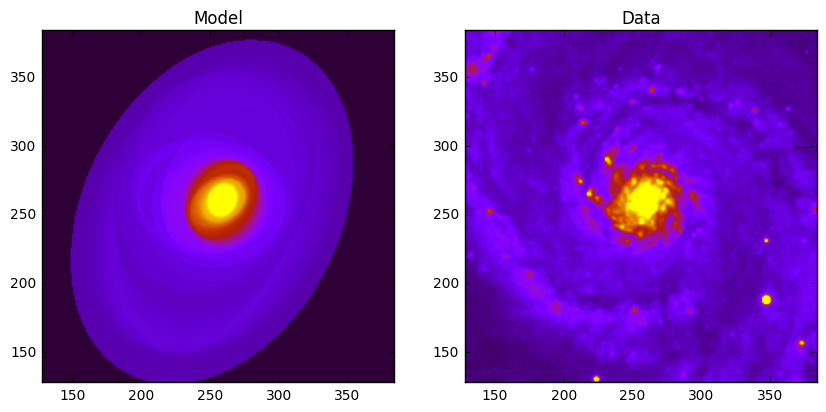

In [4]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 10))

limits = [128,384]

ax1.imshow(model_image, cmap=cm.gnuplot, vmin=0, vmax=1000)
ax1.set_xlim(limits)
ax1.set_ylim(limits)
ax1.set_title("Model")
ax2.imshow(pixel_data, cmap=cm.gnuplot, vmin=0, vmax=1000)
ax2.set_xlim(limits)
ax2.set_ylim(limits)
ax2.set_title("Data")

Finally, subtract model from data:


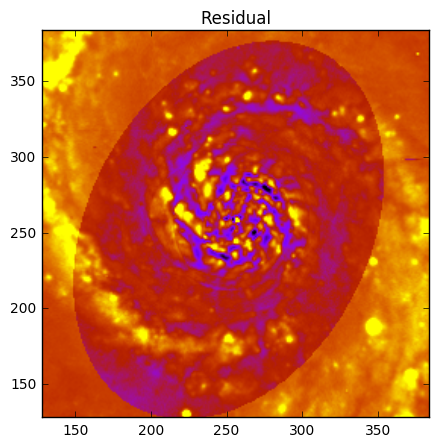

In [5]:
residual = pixel_data - model_image

fig, ax = plt.subplots(figsize=(5, 5))
ax.imshow(residual, cmap=cm.gnuplot, vmin=-200, vmax=200)
limits = [128,384]
ax.set_xlim(limits)
ax.set_ylim(limits)
ax.set_title("Residual")

## Elliptical galaxy test image

Of course, M51 is not the best object to test this procedure, since the non-elliptical contamination is so significant.

Better results for demo purposes can be obtained from a "true" elliptical galaxy. We chose a public-domain image of M105 as published at asd.gsfc.nasa.gov

We repeat the procedure above but this time passing a Geometry instance to the Ellipse constructor, since the galaxy center does not coincide with the image frame center. We also pass first guess values for the ellipticity and position angle parameters, gleaned from visually inspecting the image.

In [6]:
image = fits.open("../../test/data/M105-S001-RGB.fits")
pixel_data = image[0].data[0]

from ellipse.geometry import Geometry
g = Geometry(530., 511, 10., 0.1, 10./180.*3.14)

ellipse = Ellipse(pixel_data, geometry=g)
isolist = ellipse.fit_image()

model_image = build_model(pixel_data, isolist, fill=np.mean(pixel_data[20:120,20:120]))
model = model_image
data = pixel_data
residual = data - model

Centering on object....   Done. Found x0 = 530.0, y0 = 512.0
#
# Semi-      Isophote         Ellipticity    Position     Grad.   Data  Flag Iter. Stop
# major        mean                           Angle        rel.                    code
# axis       intensity                                    error
#(pixel)                                     (degree)
#
  10.00     1512.34 ( 0.06)  0.066 (0.000)  12.19 ( 0.2)  0.013    61     0   20     0
  11.00     1505.58 ( 0.06)  0.074 (0.000)  13.00 ( 0.2)  0.015    67     0   10     0
  12.10     1499.54 ( 0.07)  0.077 (0.001)  12.89 ( 0.2)  0.016    74     0   10     0
  13.31     1494.16 ( 0.05)  0.082 (0.000)  12.69 ( 0.2)  0.016    81     0   10     0
  14.64     1489.53 ( 0.05)  0.083 (0.000)  12.11 ( 0.2)  0.019    89     0   10     0
  16.11     1485.90 ( 0.05)  0.088 (0.001)  10.68 ( 0.2)  0.023    97     0   10     0
  17.72     1483.12 ( 0.05)  0.097 (0.001)  11.79 ( 0.2)  0.027   106     0   10     0
  19.49     1480.81 ( 0.04)  0.1

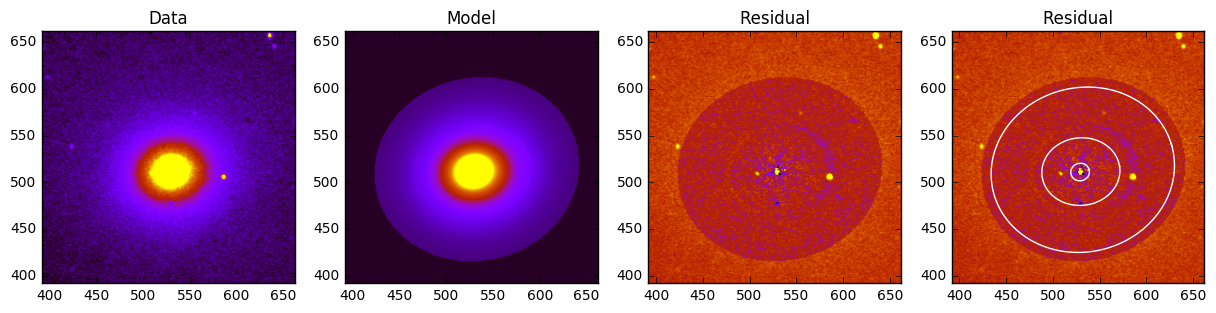

In [7]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(15, 10))
limits = [512-120,512+150]
ax1.imshow(data, cmap=cm.gnuplot, vmin=1464., vmax=1480.)
ax1.set_xlim(limits)
ax1.set_ylim(limits)
ax1.set_title("Data")
ax2.imshow(model, cmap=cm.gnuplot, vmin=1464., vmax=1480.)
ax2.set_xlim(limits)
ax2.set_ylim(limits)
ax2.set_title("Model")
ax3.imshow(residual, cmap=cm.gnuplot, vmin=-3, vmax=3)
ax3.set_xlim(limits)
ax3.set_ylim(limits)
ax3.set_title("Residual")
ax4.imshow(residual, cmap=cm.gnuplot, vmin=-3, vmax=3)
ax4.set_xlim(limits)
ax4.set_ylim(limits)
ax4.set_title("Residual")

# overplot a few isophotes on the residual map
iso1 = isolist.get_closest(10.)
iso2 = isolist.get_closest(40.)
iso3 = isolist.get_closest(100.)

plt.axis([512-120,512+150,512-120,512+150])
x, y, = iso1.sampled_coordinates()
plt.plot(x, y, color='white')
x, y, = iso2.sampled_coordinates()
plt.plot(x, y, color='white')
x, y, = iso3.sampled_coordinates()
plt.plot(x, y, color='white')

The residuals in more detail.

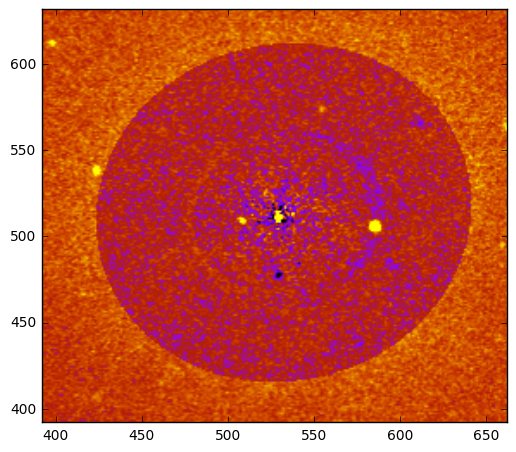

In [8]:
fig, ax = plt.subplots(figsize=(6, 6))
plt.axis([512-120,512+150,512-120,512+120])
ax.imshow(residual, cmap=cm.gnuplot, vmin=-2, vmax=2)

Note how the residuals are affected by the bright star image about 50 pixels to the right of the nucleus. The "isophote" that intercepts that star image contains a significant non-elliptical component caused by the inclusion of the bright star in the intensity sample extracted from the image. This is a good candidate to be processed by sigma-clipping, as explained in script 'example_sclip.ipynb' (see below).

Out of curiosity, lets see how the radial profiles look like.

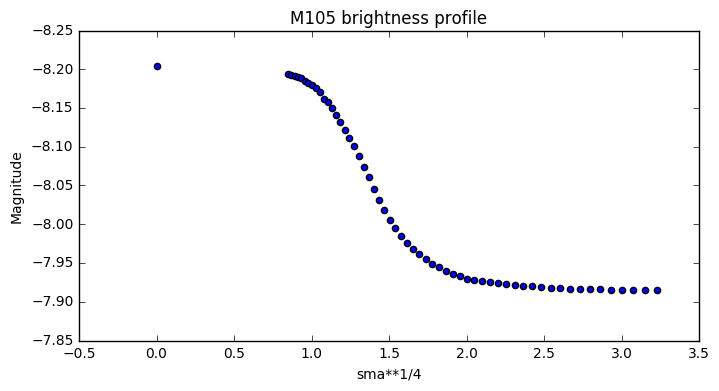

In [9]:
plt.figure(figsize=(8, 4))

plt.scatter(isolist.sma**0.25, -2.5*np.log10(isolist.intens))

plt.xlabel('sma**1/4')
plt.ylabel('Magnitude')
plt.gca().invert_yaxis()
plt.title("M105 brightness profile")

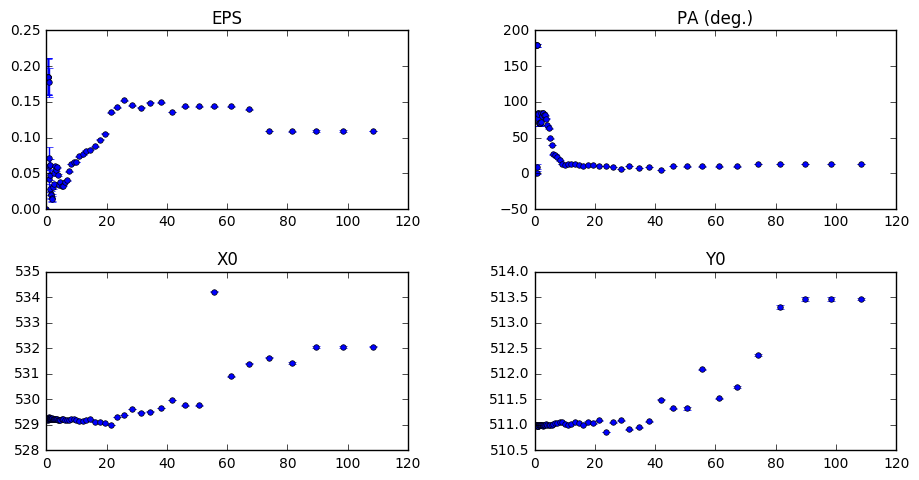

In [10]:
plt.figure(figsize=(10, 5))
plt.figure(1)

plt.subplot(221)
plt.errorbar(isolist.sma, isolist.eps, yerr=isolist.ellip_err, fmt='o', markersize=4)
plt.title('EPS')

plt.subplot(222)
plt.errorbar(isolist.sma, isolist.pa/np.pi*180., yerr=isolist.pa_err/np.pi* 80., fmt='o', markersize=4)
plt.title('PA (deg.)')

plt.subplot(223)
plt.errorbar(isolist.sma, isolist.x0, yerr=isolist.x0_err, fmt='o', markersize=4)
plt.title('X0')

plt.subplot(224)
plt.errorbar(isolist.sma, isolist.y0, yerr=isolist.y0_err, fmt='o', markersize=4)
plt.title('Y0')

plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.35, wspace=0.35)

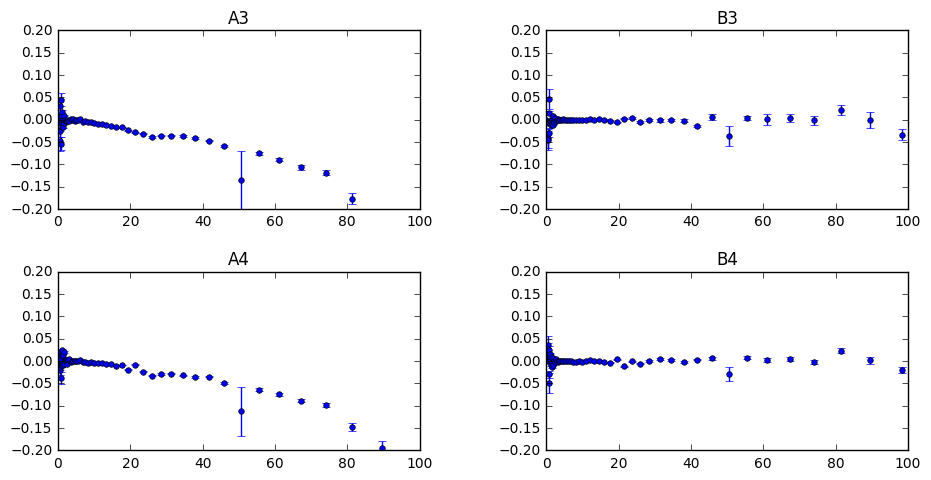

In [ ]:
plt.figure(figsize=(10, 5))
plt.figure(1)
limits = [0., 100., -0.2, 0.2]

plt.subplot(221)
plt.axis(limits)
plt.errorbar(isolist.sma, isolist.a3, yerr=isolist.a3_err, fmt='o', markersize=4)
plt.title('A3')

plt.subplot(222)
plt.axis(limits)
plt.errorbar(isolist.sma, isolist.b3, yerr=isolist.b3_err, fmt='o', markersize=4)
plt.title('B3')

plt.subplot(223)
plt.axis(limits)
plt.errorbar(isolist.sma, isolist.a4, yerr=isolist.a4_err, fmt='o', markersize=4)
plt.title('A4')

plt.subplot(224)
plt.axis(limits)
plt.errorbar(isolist.sma, isolist.b4, fmt='o', yerr=isolist.b4_err, markersize=4)
plt.title('B4')

plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.35, wspace=0.35)

Note how the presence of the bright star causes a significant non-elliptical component to appear around SMA=50 pixels.

Lets repeat the procedure with sigma-clipping enabled to see the effect on the residuals map.

Note that there is no need to create a new Ellipse instance, since nothing changed in either the input pixel map nor the input geometry.

In [ ]:
isolist_s = ellipse.fit_image(sclip=3., nclip=3, verbose=False)

model_image_s = build_model(pixel_data, isolist_s, high_harmonics=True, fill=np.mean(pixel_data[20:120,20:120]))
model_s = model_image_s
data = pixel_data
residual_s = data - model_s

Interpolating....Done


Plot residuals using a very narrow range for the pixel values.

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 10))
limits = [512-120,512+150]
ax1.imshow(residual_s, cmap=cm.gnuplot, vmin=-0.5, vmax=0.5)
ax1.set_xlim(limits)
ax1.set_ylim(limits)
ax1.set_title('With sigma-clip')
ax2.imshow(residual, cmap=cm.gnuplot, vmin=-0.5, vmax=0.5)
ax2.set_xlim(limits)
ax2.set_ylim(limits)
ax2.set_title('Without sigma-clip')